<div align="center"><font size="6">Szívbetegség vizsgálata</font></div>
<div align="center"><font size="3.5">Készítette: Balogh Kinga</font></div>


In [1]:
# alapvető matematikai műveletek
import numpy as np

# statisztikai csomagok
from scipy.stats import norm, ttest_ind, pearsonr
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.graphics.gofplots import qqplot

# regresszió
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Táblázathoz szükséges csomag
import pandas as pd

# ábrázoláshoz szükséges csomag
import matplotlib.pyplot as plt
import seaborn as sns

# Ábraméret: 10x7 inch
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)

Az adatokat UCI Machine Learning Repositry oldalról választottam ki, összesen 303 egyén adatai szerepelnek az adatsorban. Az adatok gyűjtésében a következő intézmények vettek részt:

   1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
   2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
   3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
   4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D. 

A dolgozatom célja megvizsgálni, hogy milyen összefüggések vannak az oszlopokban szereplő mennyiségek és a szívbetegség diagnózisa között. A tüneteket a korrelációk alapján választom ki, ezen belül azokat a változókat vizsgálom meg részletesen, ahol a korreláció abszolútértékben magasabb, mint $0.4$. A munkafüzett első részében megismerkedem az adattáblával: értelmeztem az oszlopok jelentéseit, megnéztem azok típusait, megvizsgálom, hogy van-e hiányzó adat, stb..

### Ismerkedés az adattáblával


Adattábla beltöltése:

In [2]:
df= pd.read_csv('dataset/heart.csv')

Első és utolsó öt sor:

In [3]:
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.tail(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


303 adatsorunk van.

#### Az oszlopok jelentései:

- age: kor
- sex: nem
  - 0: nő
  - 1: férfi
- cp: mellkasi fájdalom típusa
  - 0: tipikus angina
  - 1: atipikus angina
  - 2: nem anginális fájdalom
  - 3: tünetmentes
- trestbps: nyugalmi vérnyomás
- chol: koleszterinszint mg/dl
- fbs: vércukorszint 120 mg/dl-nél nagyobb (1) vagy kisebb (0)
- restecg: nyugalmi elektrokardiográfiai eredmények
  - 0: normál
  - 1: ST-T abnormális
  - 2: lehetséges vagy bizonyos hipertrófia
- thalach: maximális pulzusszám
- exang: terhelés indukálta a mellkasi fájdalmat
  - 0: nem
  - 1: igen
- oldpeak: ST csökkenése terhelés hatására a nyugalmi állapothoz képest
- slope: ST csúcs szegmens meredeksége
  - 0: növekvő
  - 1: lapos
  - 2: csökkenő
- ca: fluoroszkópiával megjelölt szívkamrák száma (0-3)
- thal: hemoglobin szám csökkent
  - 3: nem
  - 6: igen
  - 7: igen (visszafordítható)
- target: diagnózis
  - 0: nem beteg
  - 1: beteg


Az adatok típusai:

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

A legtöbb adatunk egész típusú az `oldpeak` kivételével, azonban "folytonos" adatok csak az `age`, `testbps`, `chol`, `thalach`, `oldpeak` oszlopokban vannak. A többi adat kategóriákra bontott.

Hiányzó adatok száma: 

In [6]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Nincs hiányzó adat.

Leíró statisztikák:

In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


A fenti táblázatból leolvasható, hogy a legfiatalabb személy 29  a legidősebb pedig 77 éves. Látható, hogy a terhelés alatti maximális pulzusszám maximuma 71, stb..

In [8]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

Az adatsorban a betegek és nem betegek száma nem különbözik jelentősen.

### A kor és pulzusszám összefüggése 


Először külön megvizsgálom az `age` változót.

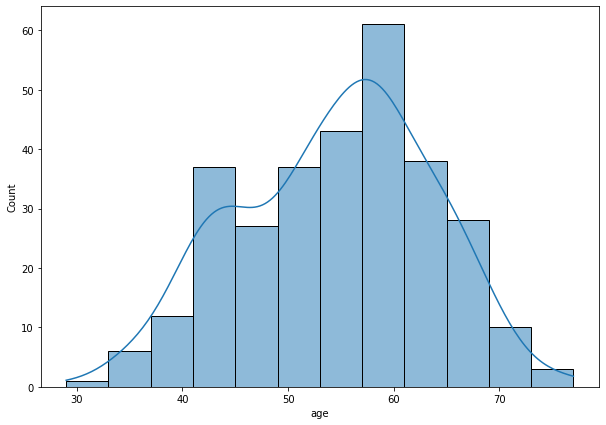

In [9]:
sns.histplot(data=df, x="age", kde=True);

A hisztogram mellett az ún. [Kernel Density Estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) görbét is ábrázoltam. Az ábra alapján úgy tűnik, hogy az az `age` adatsor normális eloszlású is lehet. Ennek ellenőrzésére Lilliefors-féle tesztet, illetve QQ-ábrát használok.

In [10]:
lilliefors(df['age'], dist='norm')

(0.07613194000239032, 0.0009999999999998899)

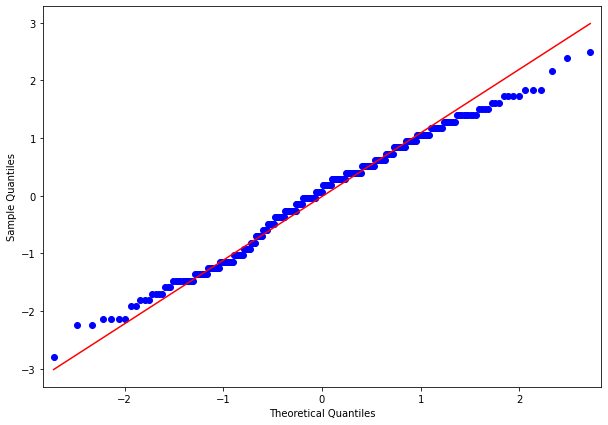

In [11]:
qqplot(df['age'],norm,fit=True,line='q');

A QQ-ábra és a $p=0.0009$ érték alapján nagy biztonsággal elutasíthatjuk azt, hogy a minta normális eloszlásból származik. 


A korrelációs együtthatók alapján vizsgáljuk meg az `age` és `thalach` összefüggését. Ismert tény, hogy az a kor előrehaladtával a terhelés alatti maximális pulzusszám csökken, ezt a tény szeretném statisztikai módszerekkel alátámasztani az adatsor alapján.

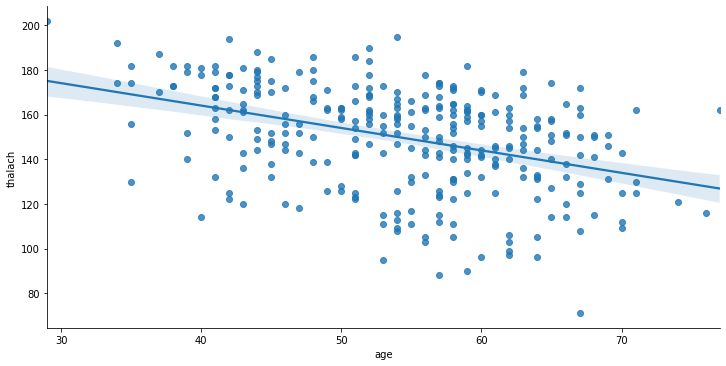

In [12]:
sns.lmplot(data=df,x="age", y="thalach",height=5, aspect=2);

Ábrázolva a terhelés alatti maximális pulzusszámot a kor függvényében már akár szemmel is leolvasható, hogy aki idősebb annak átlagosan alacsonyabb a pulzusszáma terhelés alatt.

In [13]:
pearsonr(df['age'],df['thalach'])

(-0.3985219381210673, 5.628106676351146e-13)

A kor és a terhelés alatti maximális pulzusszám korrelációja $-0.39\approx-0.4$, ami negatív kapcsolatra mutat. Pearson-féle teszttel megvizsgáltam a korrelációt és a p értéket. A p-értéke $5.63\cdot10^{-13}$, vagyis a kor és a pulzusszám között szinte biztosan van összefüggés. Ezzel alátámasztottuk a feltevésünket.

### A `target` oszlop összefüggéseinek vizsgálata

#### Pearson-féle korrelációs együtthatók

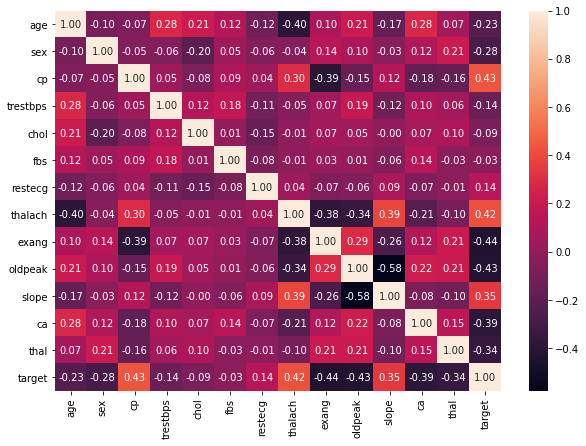

In [14]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

Vizsgáljuk a  `target` oszlop korrelációját a többi változóval. A választott $0.4$ értékű határ alapján a következőeket érdemes tovább vizsgálnunk: `cp`, `thalach`, `exang` és az `oldpeak`.

Elöször a `target` és a `cp` összefüggését vizsgálom.

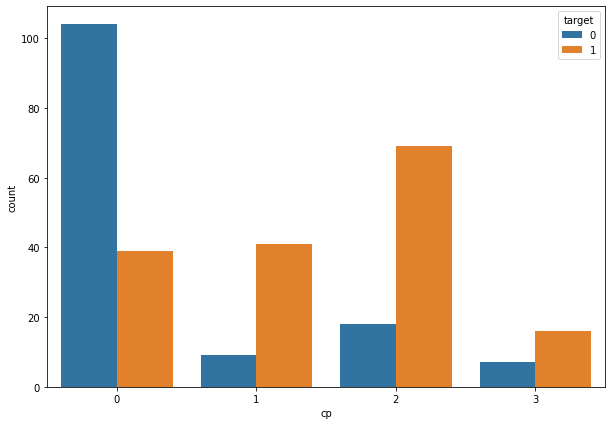

In [15]:
sns.countplot(x='cp',hue='target',data=df);

Az ábráról leolvasható, hogy a `cp` változó a `target` külön csoportjaiban másképpen viselkedik. Vizsgáljuk meg a többi változót is.

A `target` és `thalach` kapcsolatának vizsgálata:

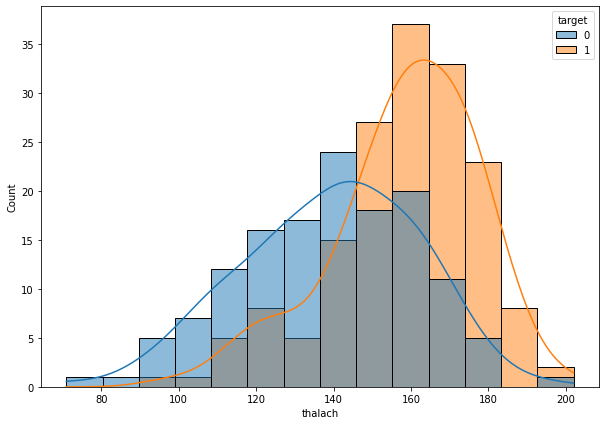

In [16]:
sns.histplot(data=df, hue="target", x="thalach", kde=True);

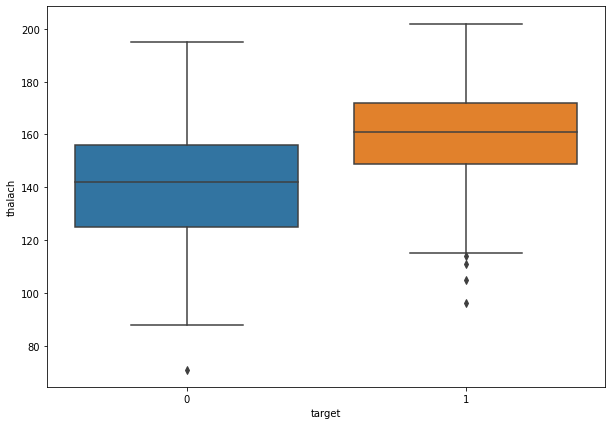

In [17]:
sns.boxplot(x="target", y="thalach", data=df);

Már az ábrák alapján is megfigyelhető, hogy a beteg egyének terhelés alatti maximális pulzusszáma átlagosan magasabb a nem betegekéhez képest. A két csoport pulzusszámnak várható értéke lényegesen különbözőnek látszik.

Ennek ellenőrzésére Welch-tesztet használok.

In [18]:
gb = df.groupby("target")['thalach']
ttest_ind(*[gb.get_group(x) for x in gb.groups],equal_var=False)

Ttest_indResult(statistic=-7.953039312035018, pvalue=5.018595443073019e-14)

A $p=5\cdot10^{-14}$, ami elég kicsi ahhoz, hogy elutasítsuk a nullhipotézist, miszerint a betegek és nem betegek pulzusszámának átlag értéke nem különbözik egymástól jelentősen.

A `target` és `exang` összefüggésének vizsgálata:

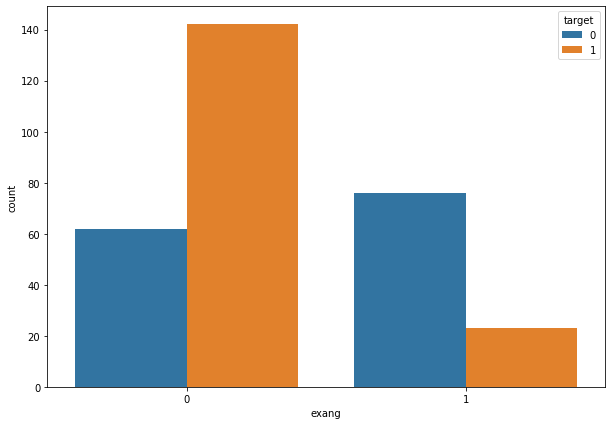

In [19]:
sns.countplot(x='exang',hue='target',data=df);

Érdekesnek tűnik, hogy a betegeknél kevésbé jellemző a terhelés hatására jelentkező fájdalom.

Az `oldpeak` és a `target` összefüggésének a vizsgálata:

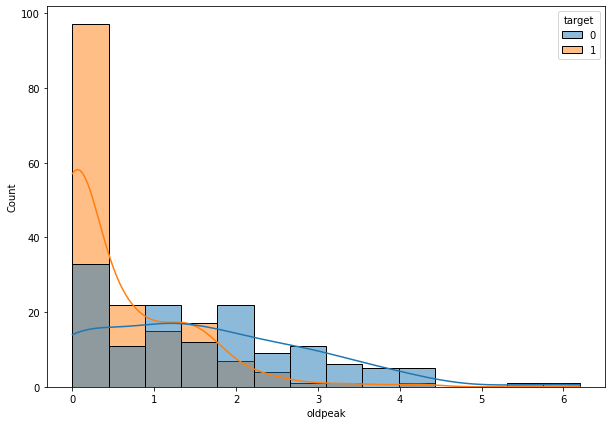

In [20]:
sns.histplot(data=df, hue="target", x="oldpeak", kde=True);

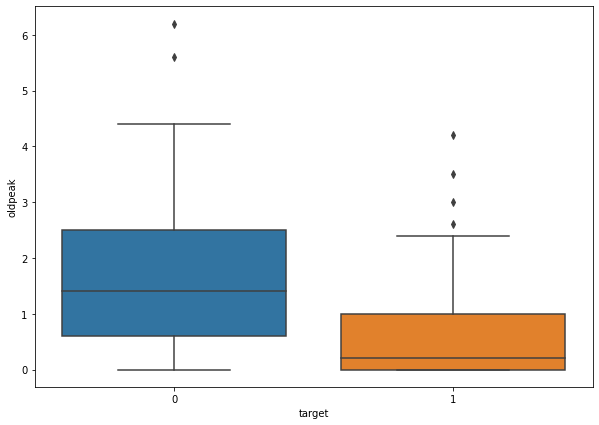

In [21]:
sns.boxplot(x="target", y="oldpeak", data=df);

Látható, hogy a betegek esetén jóval kisebb az ST  csúcs csökkenése terhelés hatására a nyugalmi állapothoz képest, mint a nem betegek esetén. Már az ábrákról is szembetűnik, hogy a  két csoport ST csúcs csökkenésének az átlag értékei jelentősen különböznek. Ennek ellenörzésére hasonlóan lehetne alkalmazni a Welch-próbát, amit most mellőzök.

#### Regresszió

A munkám fő célja, hogy tetszőleges adatok mellett minél pontosabban meg tudjuk mondani, hogy valaki beteg-e vagy sem. Mivel a `target` oszlop értéke diszkrét 1 vagy 0 lehet (vagyis szívbeteg vagy sem), ezért logisztikus regresszióval vizsgálom a problémát. 
A logisztikus regresszióban a `target` egy adott $\alpha$ csoportjába tartozás valószínűsége megadható úgy, hogy:

<div align="center"><font size="4">$P(Y=\alpha) = \frac{1}{1+e^{k}},$</font></div>

ahol

<div align="center"><font size="3">$k = a_jX_j + a_{j-1}X_{j-1} + ... + a_1X_1 +b $</font></div>
alakú.

Első lépésként leválasztjuk a megjósolandó változónkat az adattábláról.

In [22]:
df2=df.drop(('target'),axis=1)

In [23]:
df2

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


Külön vizsgálom amikor az összes, illetve csak a külön elemzett adatoszlopokat használom a regresszióhoz. 


Csak a vizsgált adatokat használva:


In [24]:
df3=df[['age','cp','thalach','exang','oldpeak']]

Az adattáblát két részre bontjuk: *train* és *test*. Erre azért van szükség, hogy később az illesztett modellt ki tudjuk értékelni olyan adatokon, amit azelőtt még sosem látott (*test*). A maradék részét az adattáblának az illesztéshez használjuk fel (*train*). Az adattábla $20 \%$-át használom *test* adatsorként.

In [65]:
X_train, X_test, y_train, y_test=train_test_split(df3,df['target'],test_size=0.2,shuffle=True)

A *train* adatsoron illesztést végzünk.

In [66]:
reg=LogisticRegression(solver='newton-cg').fit(X_train, y_train)

Értékeljük ki, hogy milyen pontos a regresszió a *test* adatsoron.

In [67]:
reg.score(X_test, y_test)

0.7540983606557377

Kiértékelve a modellt 75 %-os pontosságot értünk el (kis mértékben változhat, az adatok véletlenszerű csoportosítása, illetve az optimalizáló algoritmus miatt).

Tetszőleges adatokat használva (a megfelelő sorrendben) nézzük meg, hogy betegek vagyunk-e.

*Megjegyzés: A modell csak akkor működhet jól, ha a megadott változók a train adatsor tartományában belül vannak.*

In [68]:
reg.predict(np.array([45,0,140,0,1.2]).reshape(1, -1))

array([0], dtype=int64)

In [69]:
reg.predict_proba(np.array([45,0,140,0,1.2]).reshape(1, -1))

array([[0.54386192, 0.45613808]])

A modell alapján a tetszőleges adatokkal nem vagyunk betegek, viszont a jóslás valószínűségét vizsgálva láthatjuk, hogy az eredményünk bizonytalan.

A regresszióhoz használjuk a teljes adatsort:

In [85]:
X_train2, X_test2, y_train2, y_test2=train_test_split(df2,df['target'],test_size=0.2,shuffle=True)

In [86]:
reg2=LogisticRegression(solver='newton-cg').fit(X_train2, y_train2)

In [87]:
reg2.score(X_test2, y_test2)

0.8688524590163934

Kiértékelve a modellt 86 %-os pontosságot értünk el (kis mértékben változhat).

Tetszőleges adatokkal:

In [88]:
reg2.predict(np.array([70,0,0,120,400,0,1,120,0.2,5,3,4,3]).reshape(1, -1))

array([0], dtype=int64)

In [89]:
reg2.predict_proba(np.array([70,0,0,120,400,0,1,120,0.2,5,3,4,3]).reshape(1, -1))

array([[0.98377896, 0.01622104]])

Látható, hogyha az egész adatsort figyelembe vesszük, akkor a modell pontosabb. Ez azt mutatja, hogy olyan nemlineáris, bonyulultabb kapcsolatokat is felfedezett az algoritmus, amit a korrelációs táblázatból nem tudtunk megfigyelni.